In [1]:
from scipy.integrate import ode
from scipy.interpolate import interp1d
import pandas as pd
from astropy import units as u
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
import time
from scipy.optimize import minimize, approx_fprime
import matplotlib as mpl

In [2]:
G = 6.67259e-8 # dyne cm2 g-2
c = 2.99792458e10 # cms-1
n_den = 2.3e14
km2cm = 1e5
msun = 1.98847e33
path = "eos_data/sly230a.csv"

def df_to_ep(df):
    e_den = df.energy_densityc2
    e_den_normed = e_den#/n_den
    p = df.pressurec2
    e_den_normed = e_den_normed*((2.99792458e10)**2)
    pressure = p*((2.99792458e10)**2)
    return e_den_normed.to_numpy(), pressure.to_numpy()
### EOS DATA ###
def get_ep(e, p):
    f_e_smooth = interp1d(p, e, fill_value=(0, 0), kind = "cubic", bounds_error=True)
    return f_e_smooth
def get_pe(p, e):
    f_e_smooth = interp1d(e, p, fill_value=(0, 0), kind = "cubic", bounds_error=True)
    return f_e_smooth

# Load EOS
df = pd.read_csv(path)
e_arr, p_arr = df_to_ep(df)
EOS = get_ep(e_arr, p_arr)

In [3]:
def dedP_helper(p_arr, e_arr):
    return np.gradient(e_arr, p_arr), e_arr

def dedP(p_arr, e_arr):
    dedp_helper, e_arr = dedP_helper(p_arr, e_arr)
    return interp1d(e_arr, dedp_helper, fill_value="extrapolate", kind = "cubic")

dedp = dedP(p_arr, e_arr)

def drhodP(e_arr, dedp = dedp):
    return (c**-2) * dedp(e_arr)

In [4]:
def _b(r, m):
    return G*m/((c**2)*r)
def _lamda(r, m):
    return 0.5*np.log(1/(1-2*_b(r,m)))
def _Q(r, p, m):
    frac = (c**-4) * (4 * np.pi * G * (r**2) * p)
    return _b(r,m) + frac    

def _dPhidr(r, P, M):
    factor1 = G/(c**2) 
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return factor1*num/dem

In [5]:
# DIMENSIONS CHECKED
def _dMdr(r, e):
    return 4 * np.pi * r**2 * (e/(c**2))

# DIMENSIONS CHECKED
def _dPdr(r, P, M, e):    
    num = (M+4*np.pi*(r**3)*P/(c**2))
    dem = r * (r-2*G*M/(c**2))
    return -1 * (e+P) * G/(c**2) * num/dem

In [6]:
def _dWdr(r, omega, c_ad2_inv, lamda, phi, dphidr, W, V, l):
    brackets = ((omega*r)**2)/(c**2) * np.exp(lamda-2*phi) + dphidr * W
    return c_ad2_inv * brackets - l*(l+1)*np.exp(lamda)*V

def _dVdr(r, dphidr, V, W, lamda):
    return 2 * dphidr * V - np.exp(lamda) * W/(r**2)

In [7]:
def coupledTOV(r, VEC, init_params):
    p, m, phi, W, V = VEC
    EOS, l, omega = init_params
    if p < p_min: 
        return [0, 0, 0, 0, 0]
    lamda = _lamda(r, m)
    Q = _Q(r, p, m)
    e = EOS(p) 
    c_ad2_inv = drhodP(e)
    dPdr = _dPdr(r, p, m, e)
    dMdr = _dMdr(r, e)
    dPhidr = _dPhidr(r, p, m)
    dWdr = _dWdr(r, omega, c_ad2_inv, lamda, phi, dPhidr, W, V, l)
    dVdr = _dVdr(r, dPhidr, V, W, lamda)
    return [dPdr, dMdr, dPhidr, dWdr, dVdr]

In [8]:
def boundary_wv(r_R, m_R, omega, w_R, v_R, phi_R, p_R):
    dphidr_R = _dPhidr(r_R, p_R, m_R)
    lamda = _lamda(r_R, m_R)
    return ((omega*r_R)**2)/(c**2) * np.exp(lamda - 2*phi_R) * v_R + dphidr_R * w_R 

In [9]:
# Initial Conditions
km2cm = 1e5
r_i = 1
p0 = p_arr[-34]
e0 = EOS(p0)
p_c = p0 - 2 * np.pi * (G/(c**4)) * r_i**2 * (p0 + e0) * (3*p0 + e0)/3
e_c = EOS(p_c)
m0 = e_c/(c**2) * 4/3 * np.pi * r_i**3
omega = 2e3*(2*np.pi) #Arbitrary guess
l=2
phi0 = -1 # Two step integration optimization: similar to phi previously.
C = 1
W0 = C*(r_i ** (l+1))
V0 = -C/l * (r_i **l)
p_min = 1*(c**2)

init_VEC = [p_c, m0, phi0, W0, V0]
init_params = [EOS, l, omega]
init_t = [r_i, 21 * km2cm]
eval_t = np.linspace(r_i, 20 * km2cm, 1000)

# SOLVE COUPLED ODE ANOTHER WAY HERE.
from scipy.integrate import solve_ivp
sol = solve_ivp(fun = coupledTOV, 
               t_span = init_t,
               y0 = init_VEC,
               args = [init_params],
               method = "Radau",
               t_eval = eval_t)

p_total = sol.y[0]
try: 
    surface_idx = np.where(np.diff(p_total) == 0)[0][0]
except:
    surface_idx = len(sol.y[0])
p, m, phi, w, v = sol.y[:, :surface_idx]
r_arr = sol.t[:surface_idx]

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

print("== First Integration == ")
print(f"Star has mass {m_R/msun:.3f} Msun and radius {r_R/km2cm:.3f}km")
print(f"Interior Surface: {np.exp(2*phi_R):.8f}")
print(f"Exterior Surface: {(1-2*G*m_R/(c**2*r_R)):.8f}")
print(f"phi0 Round 1: {phi0}")
print(f"Lamda Round 2: {_lamda(r_R, m_R)}")
print(f"Boundary Term: {boundary_wv(r_R, m_R, omega, w_R, v_R, phi_R, p_R)}")

phi_ext = - 2 * _lamda(r_R, m_R)
phi_int = phi_R #At surface
delta_phi = phi_int - phi_ext
phi0 =  phi0 - delta_phi
init_VEC = [p_c, m0, phi0, W0, V0]

time.sleep(0.2)

sol = solve_ivp(fun = coupledTOV, 
               t_span = init_t,
               y0 = init_VEC,
               args = [init_params],
               method = "Radau",
               t_eval = eval_t)

p_total = sol.y[0]
try: 
    surface_idx = np.where(np.diff(p_total) == 0)[0][0]
except:
    surface_idx = len(sol.y[0])
p, m, phi, w, v = sol.y[:, :surface_idx]
r_arr = sol.t[:surface_idx]

max_idx = np.argmax(m)
m_R = m.max() # In units of msun
r_R = r_arr[max_idx] # In units of km
p_R = p[max_idx] #cgs
ec_R = EOS(p_R) #cgs
phi_R = phi[max_idx] #cgs
v_R = v[max_idx]
w_R = w[max_idx]

print()
print("== Corrected Integration == ")
print(f"Star has mass {m_R/msun:.3f} Msun and radius {r_R/km2cm:.3f}km")
print(f"Interior Surface: {np.exp(phi_R):.8f}")
print(f"Exterior Surface: {(1-2*G*m_R/(c**2*r_R)):.8f}")
print(f"phi0 Round 2: {phi0}")
print(f"Lamda Round 2: {_lamda(r_R, m_R)}")
print(f"Boundary Term: {boundary_wv(r_R, m_R, omega, w_R, v_R, phi_R, p_R)}")

== First Integration == 
Star has mass 1.360 Msun and radius 11.852km
Interior Surface: 0.21144275
Exterior Surface: 0.66123754
phi0 Round 1: -1
Lamda Round 2: 0.206821069502715
Boundary Term: -1362080192810.9712

== Corrected Integration == 
Star has mass 1.360 Msun and radius 11.832km
Interior Surface: 0.66096770
Exterior Surface: 0.66066511
phi0 Round 2: -0.6367416347120625
Lamda Round 2: 0.20725410136506983
Boundary Term: -290903881586.08997


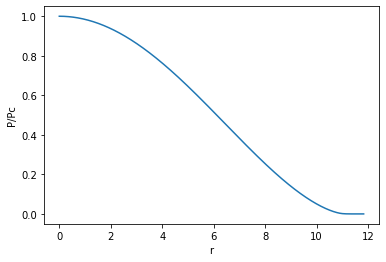

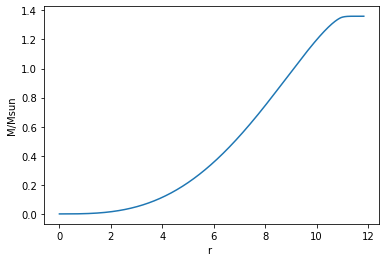

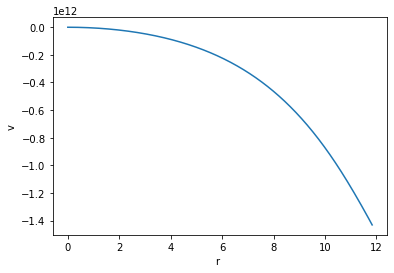

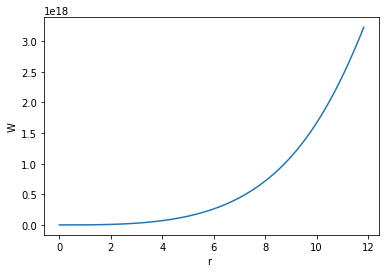

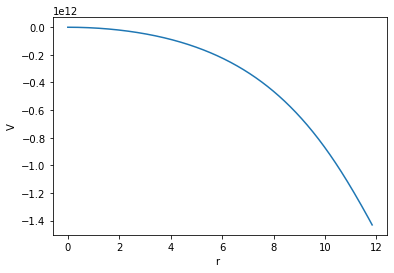

In [10]:
r_arr = r_arr/km2cm

plt.figure()
plt.plot(r_arr, p/p_c)
plt.xlabel("r")
plt.ylabel("P/Pc")

plt.figure()
plt.plot(r_arr, m/msun)
plt.xlabel("r ")
plt.ylabel("M/Msun")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("v")
plt.show()

plt.figure()
plt.plot(r_arr, w)
plt.xlabel("r ")
plt.ylabel("W")
plt.show()

plt.figure()
plt.plot(r_arr, v)
plt.xlabel("r ")
plt.ylabel("V")
plt.show()

<IPython.core.display.Javascript object>


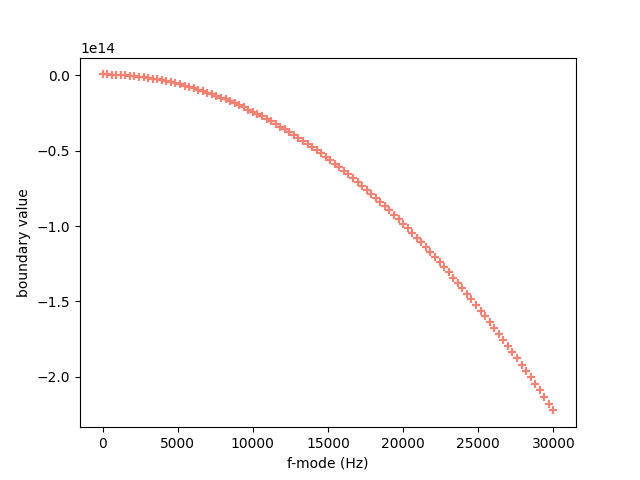


fmode:1818.1912121212124


In [12]:
# Delete when shifting over to python
old_backend = mpl.get_backend() 
%matplotlib notebook 
# ====================================================================================
fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()
plt.xlabel("f-mode (Hz)")
plt.ylabel("boundary value")

def plot_boundary(omega, p = p, EOS = EOS):
    # Repeat integration

    # Integrate
    sol = solve_ivp(fun = coupledTOV, 
                   t_span = init_t,
                   y0 = init_VEC,
                   args = [init_params],
                   method = "Radau",
                   t_eval = eval_t)

    p_total = sol.y[0]
    try: 
        surface_idx = np.where(np.diff(p_total) == 0)[0][0]
    except:
        surface_idx = len(sol.y[0])
    p, m, phi, w, v = sol.y[:, :surface_idx]
    r_arr = sol.t[:surface_idx]

    max_idx = np.argmax(m)
    m_R = m.max() # In units of msun
    r_R = r_arr[max_idx] # In units of km
    p_R = p[max_idx] #cgs
    ec_R = EOS(p_R) #cgs
    phi_R = phi[max_idx] #cgs
    v_R = v[max_idx]
    w_R = w[max_idx]
    
    f = omega/(2*np.pi)
    bc2 = boundary_wv(r_R, m_R, omega, w_R, v_R, phi_R, p_R)
    ax.scatter(f, bc2, color = "salmon", marker = "+")
    fig.canvas.draw()
    return bc2, f

omega_guess = np.linspace(0.01*(2*np.pi), 15e3*(2*np.pi), int(1e2))

bc_list = []
f_list = []
for omega in tqdm(omega_guess):
    bc_list.append(plot_boundary(omega)[0])
    f_list.append(plot_boundary(omega)[1])

bc_arr = np.array(bc_list)
f_arr = np.array(f_list)
mpl.use(old_backend) # Delete when shifting over to python

fmode = f_arr[(np.abs(bc_arr)).argmin()]
print(f"fmode: {fmode}")